In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Data Downloading

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_train.csv.zip', index_col=0)
pd.set_option('display.max_colwidth', None)
train.head(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0
266232,101283,163744,Which is the best place to reside in India and Why?,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?,Why don't many people posting questions on Quora check Google first?,1


In [4]:
test = pd.read_csv('drive/MyDrive/ML/Final Project Quora/quora_question_pairs_test.csv.zip', index_col=0)
test.head(5)

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
305985,429434,429435,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
5193,10230,10231,At what valuation did Homejoy raise money in December of 2013?,"Should a wealthy founder self-fund his second startup then raise money at high valuation after getting traction, or raise money at low valuation before any traction?",0
123326,199422,199423,How do we judge?,How do I judge my love?,0
368557,327674,498931,Are Adderall and meth the same?,Are concerta and meth test the same?,0
369226,499645,499646,"If you had internet access to only one site for the rest of your life, which site would you pick?",Why is there .co.uk for British internet sites but only .fr for French ones?,0


##Exploratory data analysis (EDA)

In [5]:
print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')

Train size: (323432, 5)
Test size: (80858, 5)


In [6]:
train.isna().sum()

,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


There are only 3 rows with null values, so we can simply drop it.

In [7]:
train.dropna(inplace=True)

In [8]:
test.isna().sum()

,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323429 non-null  int64 
 1   qid2          323429 non-null  int64 
 2   question1     323429 non-null  object
 3   question2     323429 non-null  object
 4   is_duplicate  323429 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


###Class distribution

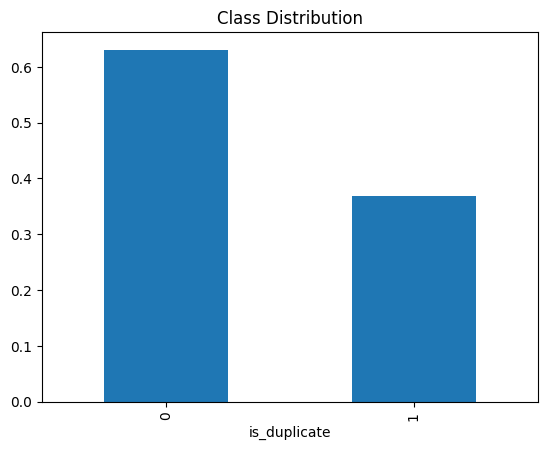

In [10]:
train['is_duplicate'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')
plt.show()

The difference in balance approximately 20% - so it is well-balanced dataset.

###Number of unique questions

Number of unique questions: 449787
Questions that appear more than 1 time: 85896 questions, 19% of unique questions


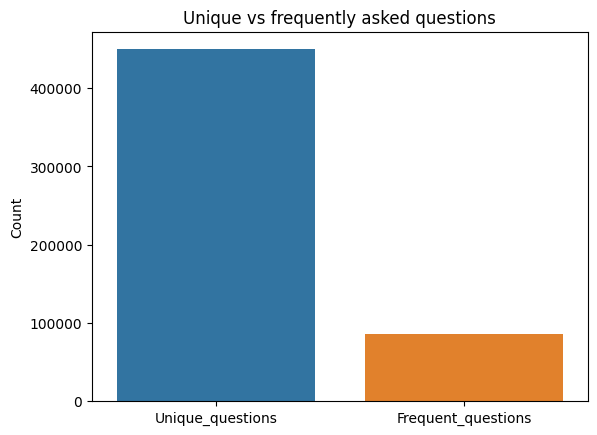

In [ ]:
all_questions = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
unique_questions =  len(np.unique(all_questions))
frequent_questions = (all_questions.value_counts()>1).sum()
percentage_frequent = frequent_questions/unique_questions*100
print(f'Number of unique questions: {unique_questions }')
print(f'Questions that appear more than 1 time: {frequent_questions} questions, {percentage_frequent:.0f}% of unique questions')

df_questions = pd.DataFrame({'Unique_questions':[unique_questions], 'Frequent_questions': [frequent_questions]})
sns.barplot(data=df_questions)
plt.title('Unique vs frequently asked questions')
plt.ylabel('Count')
plt.show()

Most of the questions asked on Quora are unique. Only 19% of them are repeated more than once.

###Length of questions

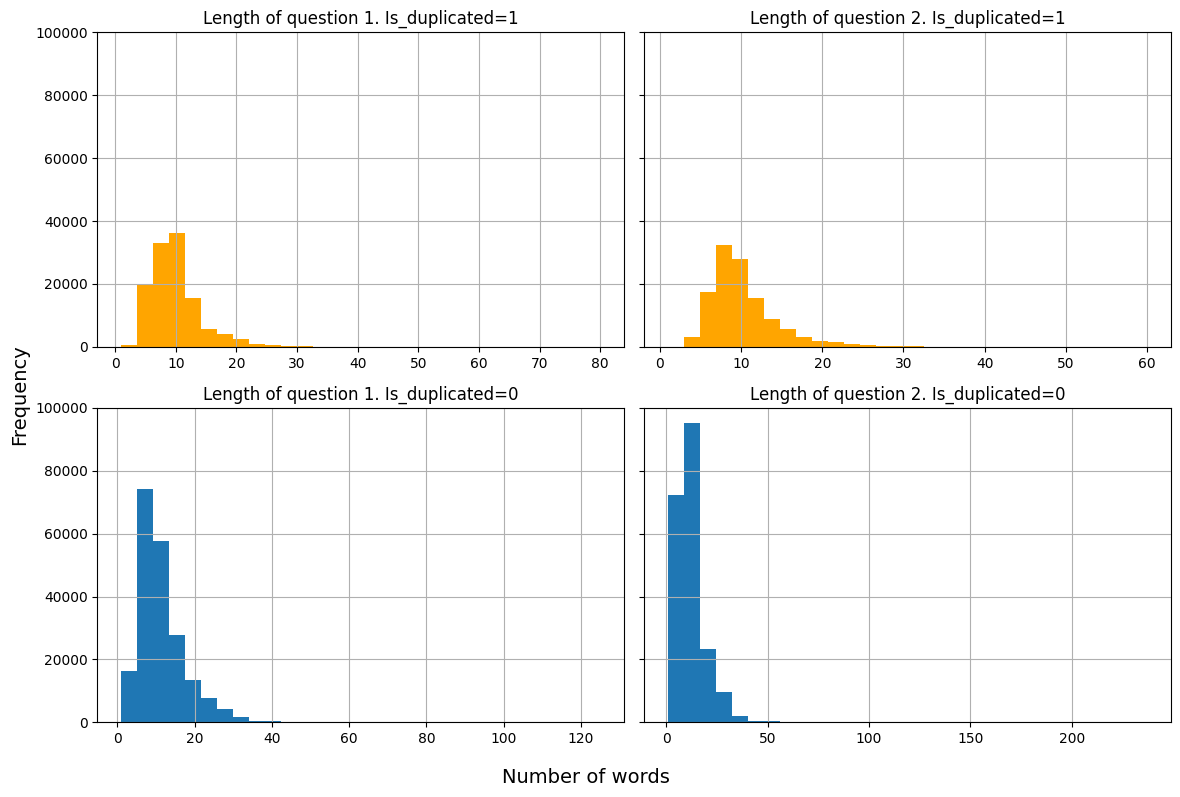

In [ ]:
train['len_q1'] = train['question1'].apply(lambda x: len(x.split()))
train['len_q2'] = train['question2'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(2,2, figsize=(12,8), sharey=True)

train[train['is_duplicate'] == 1]['len_q1'].hist(bins=30, ax=ax[0,0], color='orange')
ax[0,0].set_title('Length of question 1. Is_duplicated=1')

train[train['is_duplicate'] == 1]['len_q2'].hist(bins=30, ax=ax[0,1], color='orange')
ax[0,1].set_title('Length of question 2. Is_duplicated=1')

train[train['is_duplicate'] == 0]['len_q1'].hist(bins=30, ax=ax[1,0])
ax[1,0].set_title('Length of question 1. Is_duplicated=0')

train[train['is_duplicate'] == 0]['len_q2'].hist(bins=30, ax=ax[1,1])
ax[1,1].set_title('Length of question 2. Is_duplicated=0')


fig.supxlabel('Number of words', fontsize=14)
fig.supylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

The lengths of Question 1 and Question 2 are longer for non-duplicate pairs compared to duplicate ones. Additionally, Question 2 appears to be longer than Question 1 in both cases.

###Difference in length of words between questions

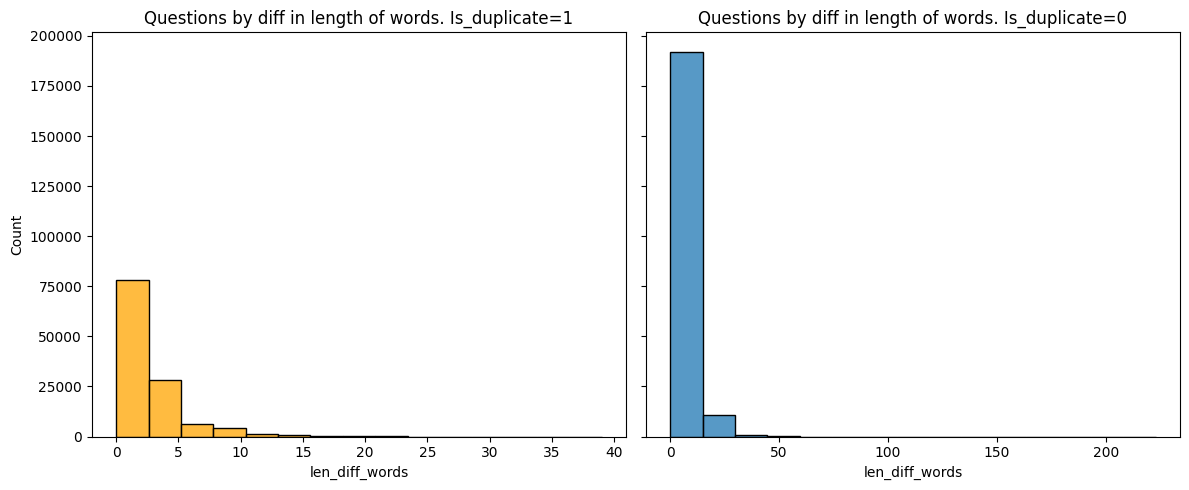

In [ ]:
train['len_diff_words'] = abs(train['len_q1'] - train['len_q2'])

fig, ax= plt.subplots(1, 2, figsize = (12, 5), sharey=True)

sns.histplot(data=train[train['is_duplicate']==1]['len_diff_words'], bins=15, ax=ax[0],color='orange')
sns.histplot(data=train[train['is_duplicate']==0]['len_diff_words'], bins=15, ax=ax[1])
ax[0].set_title('Questions by diff in length of words. Is_duplicate=1')
ax[1].set_title('Questions by diff in length of words. Is_duplicate=0')

plt.tight_layout()
plt.show()

The distribution of word differences between Question 1 and Question 2 for duplicate pairs is narrower compared to non-duplicate pairs. This suggests that duplicate questions tend to have similar lengths, reinforcing that they are likely paraphrased or reworded versions of each other. There are more extreme outliers in the non-duplicate group, while such outliers are almost absent in duplicates.

###Questions that start with the same word

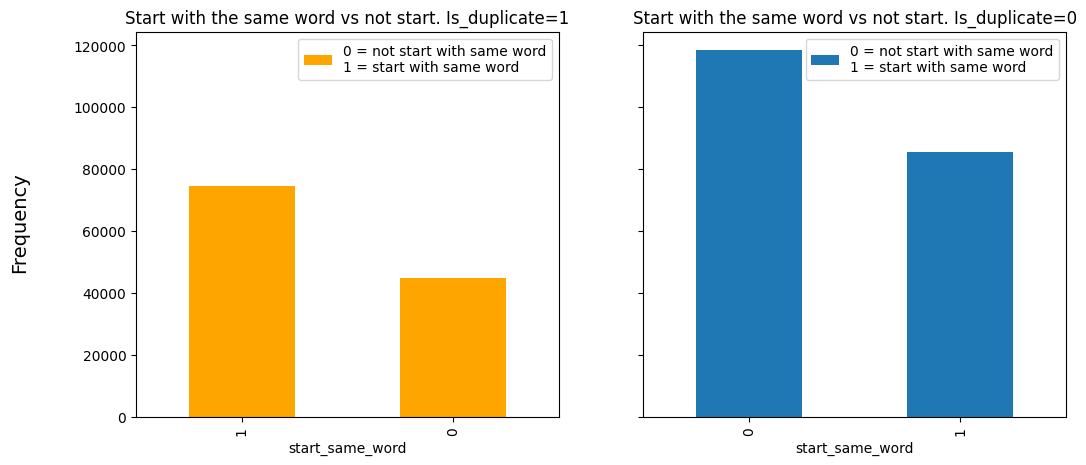

In [ ]:
train['start_same_word'] = train.apply(lambda row:  row['question1'].split()[0].lower() == row['question2'].split()[0].lower(), axis=1).astype('int')

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

train[train['is_duplicate']==1]['start_same_word'].value_counts().plot(kind='bar', ax=ax[0], color='orange')
train[train['is_duplicate']==0]['start_same_word'].value_counts().plot(kind='bar', ax=ax[1])

ax[0].set_title('Start with the same word vs not start. Is_duplicate=1')
ax[1].set_title('Start with the same word vs not start. Is_duplicate=0')

for a in ax:
    a.legend(['0 = not start with same word\n1 = start with same word'])

fig.supylabel('Frequency', fontsize=14)
plt.show()

The duplicate pairs mostly starts with the same word compared to non-duplicate ones.

###Common words in questions

In [ ]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    #Create stopword_list
    stopword_list = stopwords.words('english')

    #Remove 'exclude_words' from stopword_list to keep these in my text
    stopword_list = set(stopword_list) - set(exclude_words)

    #Add in 'extra_words' to stopword_list
    stopword_list = stopword_list.union(set(extra_words))

    #Split words in string
    words = string.split()

    #Create a list of words from my string with stopwords removed and assign to variable
    filtered_words = [word for word in words if word not in stopword_list]

    #Join words in the list back into strings and assign to a variable
    string_without_stopwords = ' '.join(filtered_words)

    return string_without_stopwords

In [ ]:
train['common_words'] = train.apply(lambda row: len(set(remove_stopwords(row['question1']).replace('?',"").split())) & len(set(remove_stopwords(row['question2']).replace('?',"").split())), axis=1)

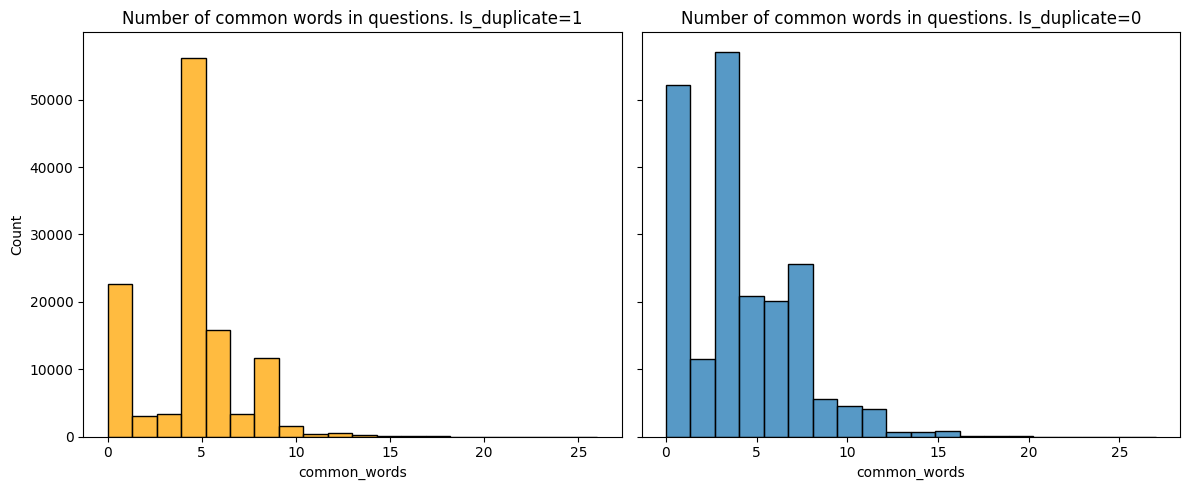

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

sns.histplot(data=train[train['is_duplicate'] == 1]['common_words'],bins=20, ax=ax[0], color='orange')
sns.histplot(data=train[train['is_duplicate'] == 0]['common_words'],bins=20, ax=ax[1])

ax[0].set_title('Number of common words in questions. Is_duplicate=1')
ax[1].set_title('Number of common words in questions. Is_duplicate=0')


plt.tight_layout()
plt.show()

The vast majority of duplicate pairs share approximately 3 to 6 common words, while most non-duplicate pairs share fewer than 3 common words.

###Does question 1 fully include question 2 or question 2 fully include question 1?

In [ ]:
train['q1 in q2']  = train.apply(lambda row: int(str(row['question1'].lower()) in str(row['question2'].lower())), axis=1 )
train['q2 in q1']  = train.apply(lambda row: int(str(row['question2'].lower()) in str(row['question1'].lower())), axis=1 )

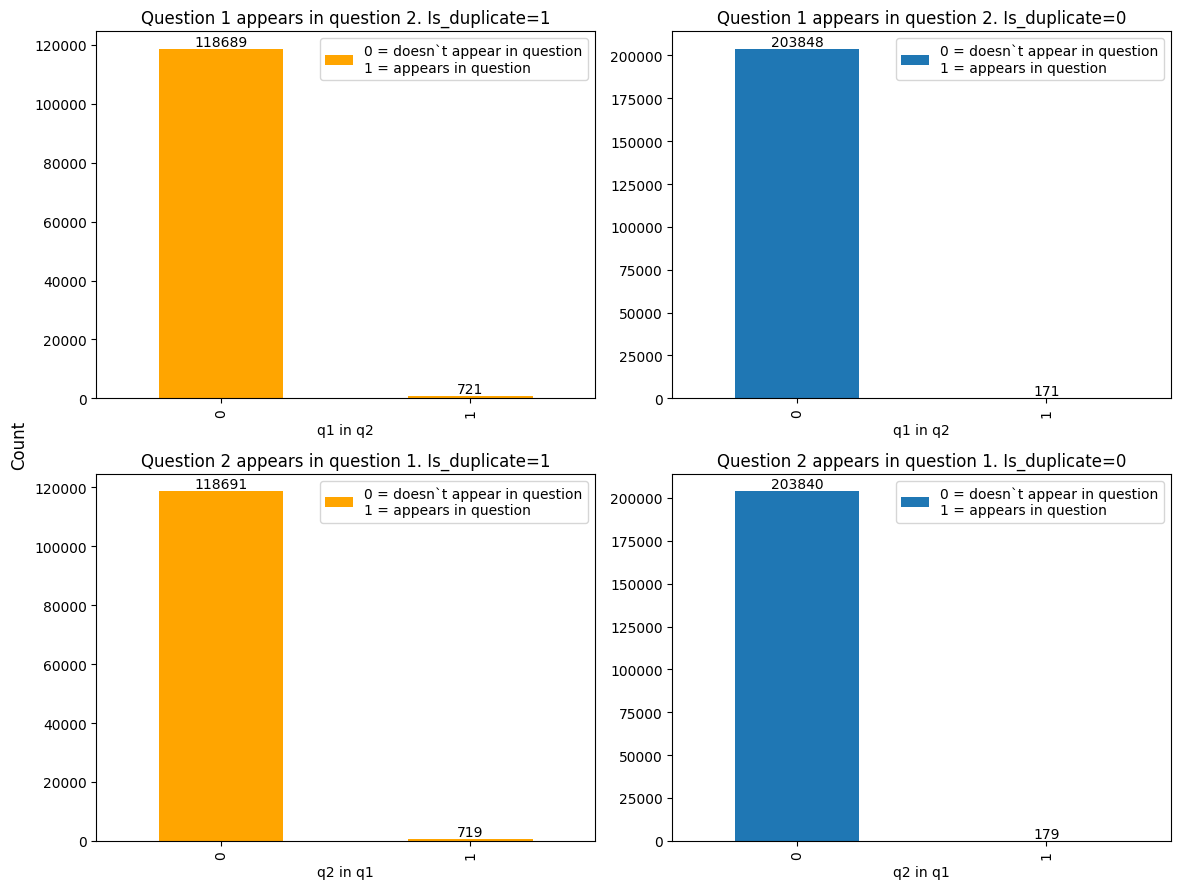

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,9))

train[train['is_duplicate'] == 1]['q1 in q2'].value_counts().plot(kind='bar', ax=ax[0,0], color='orange')
train[train['is_duplicate'] == 0]['q1 in q2'].value_counts().plot(kind='bar', ax=ax[0,1])
train[train['is_duplicate'] == 1]['q2 in q1'].value_counts().plot(kind='bar', ax=ax[1,0], color='orange')
train[train['is_duplicate'] == 0]['q2 in q1'].value_counts().plot(kind='bar', ax=ax[1,1])

ax[0,0].set_title('Question 1 appears in question 2. Is_duplicate=1')
ax[0,1].set_title('Question 1 appears in question 2. Is_duplicate=0')
ax[1,0].set_title('Question 2 appears in question 1. Is_duplicate=1')
ax[1,1].set_title('Question 2 appears in question 1. Is_duplicate=0')

for axes in ax.flat:
    for bar in axes.patches:
        axes.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                  f'{bar.get_height():.0f}', ha='center', va='bottom')
        axes.legend(['0 = doesn`t appear in question\n1 = appears in question'])

fig.supylabel('Count')
plt.tight_layout()
plt.show()

Both Question 1 and Question 2 are more likely to appear within each other in duplicate pairs compared to non-duplicate pairs.

###The most frequently used bigrams

In [ ]:
def find_bigrams(column, n, color_param, name):
  #vectorized the column
  vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
  bi_grams = vectorizer.fit_transform(column)
  names = vectorizer.get_feature_names_out()

  #count the most frequently used bigrams
  top_bigrams = pd.DataFrame(bi_grams.sum(axis=0).tolist()[0], index=names, columns=['Count'])
  top_n = top_bigrams.sort_values('Count', ascending=False).head(n)

  #plot results
  plt.rcParams["figure.figsize"] = (10,5)
  top_n.plot(kind='bar', color=color_param)
  plt.title(f'Top {n} bigrams in {name}')
  plt.xticks(fontsize=9, rotation=90)
  plt.show()


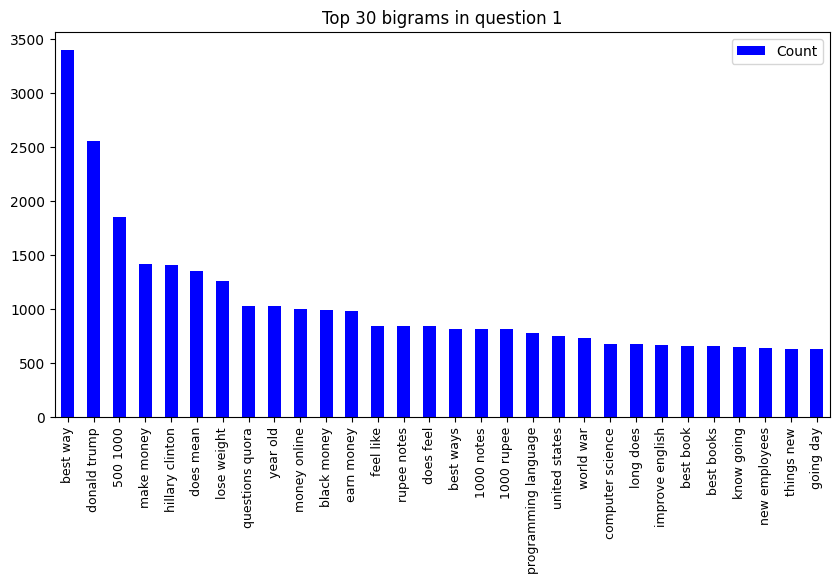

In [ ]:
find_bigrams(column=train['question1'], n=30, color_param='blue', name='question 1')

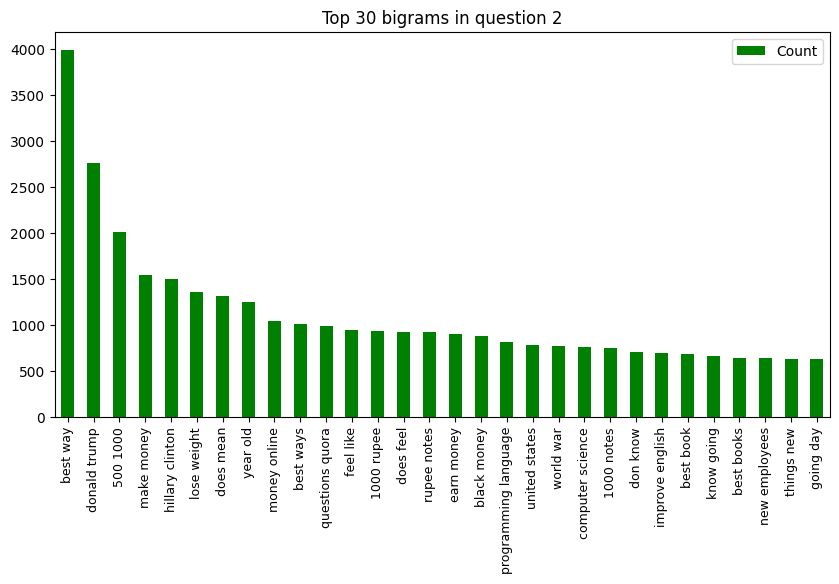

In [ ]:
find_bigrams(column=train['question2'], n=30, color_param='green', name='question 2')

Question 1 and Question 2 in general have the same frequently used bi-grams.

###The common bigrams between question 1 and question 2

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
vectorizer.fit(pd.concat([train['question1'], train['question2']]))

#create a vectorizer for question 1 and question 2
X_q1 = vectorizer.transform(train['question1'])
X_q2 = vectorizer.transform(train['question2'])

#get the list of bigrams
feature_names = vectorizer.get_feature_names_out()

In [ ]:
def get_common_bigrams_list(row_index):
    '''Find the common bi-grams between two questions'''
    q1_vec = X_q1[row_index]
    q2_vec = X_q2[row_index]

    #get the index
    q1_bigrams_idx = set(q1_vec.nonzero()[1])
    q2_bigrams_idx = set(q2_vec.nonzero()[1])

    #intersection of two sets-find common bigrams
    common_idx = q1_bigrams_idx & q2_bigrams_idx

    return [feature_names[i] for i in common_idx]

In [ ]:
#find the number of common bigrams between question 1 and question 2
train['common_bigrams_list'] = [get_common_bigrams_list(i) for i in range(0,len(train))]
train['common_bigrams_count'] =  train['common_bigrams_list'].apply(lambda x: len(x))

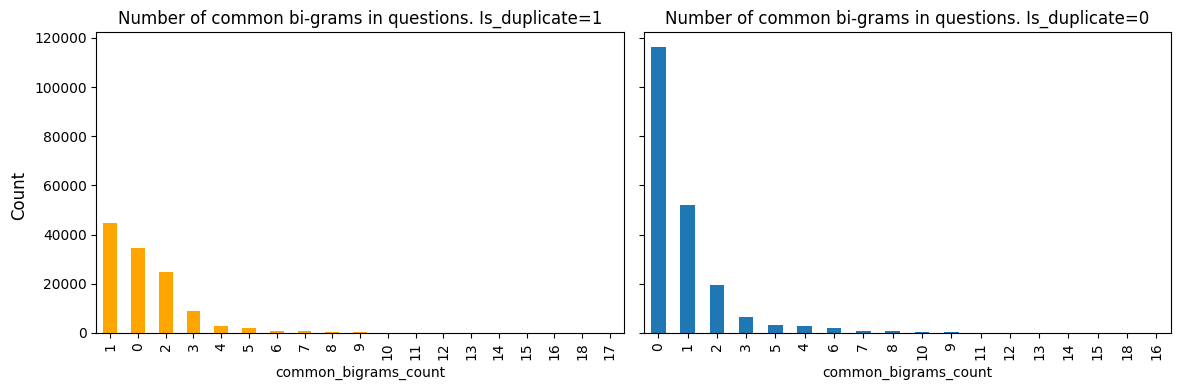

In [ ]:
#plot results
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)

train[train['is_duplicate'] == 1]['common_bigrams_count'].value_counts().plot(kind='bar', ax=ax[0], color='orange')
train[train['is_duplicate'] == 0]['common_bigrams_count'].value_counts().plot(kind='bar', ax=ax[1])

ax[0].set_title('Number of common bi-grams in questions. Is_duplicate=1')
ax[1].set_title('Number of common bi-grams in questions. Is_duplicate=0')

fig.supylabel('Count')
plt.tight_layout()
plt.show()

The vast majority of duplicate questions share at least 1 common bi-grams while the considerable number of non-duplicate questions have no common bi-grams.